# L.A. County places timeseries

In [1]:
# !/opt/anaconda3/bin/python -m pip install nb-black

In [2]:
%load_ext lab_black

In [3]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [5]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
from datetime import datetime, date

In [6]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

In [7]:
surge_begin = "2020-11-15"
surge_end = "2021-01-15"

### Counties

In [8]:
counties = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/agency-survey/counties-timeseries.csv",
    low_memory=False,
)

In [9]:
la = counties[
    (counties["county"] == "Los Angeles")
    & ((counties["date"] >= surge_begin) & (counties["date"] <= surge_end))
]

In [10]:
la.head()

,date,county,fips,population,confirmed_cases,deaths,recoveries,confirmed_cases_per_100k,deaths_per_100k,new_confirmed_cases,new_deaths,new_recoveries,agencies_count,agencies_updated,updated,in_progress
7278,2020-11-15,Los Angeles,37,10098052,339570.0,7269.0,13116.0,3362.727782,71.984181,2899.0,2.0,0.0,3.0,2.0,True,False
7279,2020-11-16,Los Angeles,37,10098052,342489.0,7275.0,13187.0,3391.634347,72.043598,2919.0,6.0,71.0,3.0,3.0,True,False
7280,2020-11-17,Los Angeles,37,10098052,344741.0,7300.0,13244.0,3413.935678,72.291171,2252.0,25.0,57.0,3.0,3.0,True,False
7281,2020-11-18,Los Angeles,37,10098052,348536.0,7337.0,13348.0,3451.517184,72.657578,3795.0,37.0,104.0,3.0,3.0,True,False
7282,2020-11-19,Los Angeles,37,10098052,353479.0,7365.0,13435.0,3500.467219,72.934859,4943.0,28.0,87.0,3.0,3.0,True,False


### Regions

In [11]:
regions = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/agency-survey/regions-cases-timeseries.csv",
    low_memory=False,
)

In [12]:
socal = regions[
    (regions["region"] == "Southern California")
    & ((regions["date"] >= surge_begin) & (regions["date"] <= surge_end))
]

In [13]:
socal[
    socal["new_confirmed_cases_seven_day_per_100k"]
    == socal["new_confirmed_cases_seven_day_per_100k"].max()
][["date", "new_confirmed_cases_seven_day_per_100k"]]

,date,new_confirmed_cases_seven_day_per_100k
1898,2021-01-10,1001.84761


In [14]:
alt.Chart(socal).mark_line().encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(tickCount=2, format=("%b. %-d"), grid=False, tickColor="#ffffff"),
    ),
    y=alt.Y(
        "new_confirmed_cases_seven_day_per_100k",
        title="",
        axis=alt.Axis(tickColor="#ffffff"),
    ),
).properties(width=500, height=300).configure_axis()

alt.Chart(...)

In [15]:
alt.Chart(la).mark_line().encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(tickCount=2, format=("%b. %-d"), grid=False, tickColor="#ffffff"),
    ),
    y=alt.Y(
        "new_confirmed_cases_seven_day_per_100k:Q",
        title="",
        axis=alt.Axis(tickColor="#ffffff"),
    ),
).properties(width=500, height=300).configure_axis()

alt.Chart(...)

---

In [16]:
cases = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/places/timeseries.csv",
    low_memory=False,
)

### Get places in Los Angeles County

In [17]:
places = cases[(cases["zcta_id"].isna()) & (cases["county"] == "Los Angeles")]

In [18]:
places_latest = places[places["date"] == places["date"].max()][
    [
        "name",
        "date",
        "new_confirmed_cases_seven_day_per_100k",
        "new_confirmed_cases_seven_day_total",
        "population",
    ]
]

In [19]:
len(places_latest)

334

In [20]:
places_latest[places_latest["name"] == "Playa Del Rey"]

,name,date,new_confirmed_cases_seven_day_per_100k,new_confirmed_cases_seven_day_total,population
134809,Playa Del Rey,2021-02-16,62.578223,2.0,3196.0


In [21]:
places_latest.head()

,name,date,new_confirmed_cases_seven_day_per_100k,new_confirmed_cases_seven_day_total,population
69237,Acton,2021-02-16,150.545728,12.0,7971.0
69575,Adams-Normandie,2021-02-16,73.152890,6.0,8202.0
69913,Agoura Hills,2021-02-16,95.771680,20.0,20883.0
70251,Agua Dulce,2021-02-16,96.200096,4.0,4158.0
70589,Alhambra,2021-02-16,109.542918,95.0,86724.0


### What's the distribution of population by place? 

In [22]:
places_latest.population.median()

16464.5

In [23]:
pop_histogram = (
    alt.Chart(places_latest)
    .mark_bar()
    .encode(
        alt.X("population:Q", bin=alt.Bin(maxbins=50), title="Population ranges"),
        alt.Y("count()", title="Places in population range"),
    )
)

### Limit the dataframe to places with > 3000 population

In [24]:
places_lrg = places[places["population"] >= 3000]

In [25]:
places_latest.population.mean()

28892.428143712576

---

### Get neightborhoods and regions in LA County from U.S. Census

In [26]:
census = pd.read_csv("output/places_totals.csv")

In [27]:
census[census["name"].str.contains("Rey")]

,name,rsa,est_pop,est_latino,est_anglo,est_black,est_asian,est_total_single_units,est_total_seven_more_units,est_total_housing_units,median_house_income,est_latino_pct,est_anglo_pct,est_black_pct,est_asian_pct,est_total_seven_more_units_pct,est_total_single_units_pct
181,Marina del Rey,Westside,5449.0,423.0,4072.0,285.0,460.0,1858.0,1.0,3435.0,103577.0,7.76,74.73,5.23,8.44,0.03,54.09
207,Del Rey,Westside,630.0,79.0,308.0,70.0,142.0,142.0,1.0,336.0,71179.0,12.54,48.89,11.11,22.54,0.30,42.26


In [28]:
places_lrg = pd.merge(places_lrg, census[["name", "rsa"]], on="name")

---

### Cases during the surge (in large places)? 

In [29]:
surge_places = places_lrg[
    (places_lrg["date"] >= surge_begin) & (places_lrg["date"] <= surge_end)
][["name", "rsa", "date", "new_confirmed_cases_seven_day_per_100k"]]

In [30]:
lacounty_all = (
    surge_places.groupby(["date"])
    .agg({"new_confirmed_cases_seven_day_per_100k": "mean"})
    .reset_index()
)

In [31]:
lacounty_all["name"] = "Los Angeles County"

In [32]:
lacounty_all["rsa"] = "Los Angeles County"

In [33]:
surge_places = surge_places.append(lacounty_all, ignore_index=True)

In [34]:
two_cities = surge_places[
    (surge_places["name"].str.contains("West Los Angeles"))
    | (surge_places["name"].str.contains("East Los Angeles"))
    | (surge_places["name"] == "Los Angeles County")
]

In [35]:
two_cities2 = surge_places[
    (surge_places["name"].str.contains("Playa Del Rey"))
    | (surge_places["name"].str.contains("Leimert Park"))
    | (surge_places["name"] == "Los Angeles County")
]

In [36]:
two_cities2.tail()

,name,rsa,date,new_confirmed_cases_seven_day_per_100k
12147,Los Angeles County,Los Angeles County,2021-01-11,914.659912
12148,Los Angeles County,Los Angeles County,2021-01-12,915.756773
12149,Los Angeles County,Los Angeles County,2021-01-13,915.888140
12150,Los Angeles County,Los Angeles County,2021-01-14,899.647901
12151,Los Angeles County,Los Angeles County,2021-01-15,865.482111


### Chart two divergent neighborhoods

In [37]:
twocities_chart = (
    alt.Chart(two_cities)
    .mark_line()
    .encode(
        x=alt.X(
            "date:T",
            axis=alt.Axis(
                tickCount=4,
                format=("%b. %-d"),
                grid=False,
                tickColor="#ffffff",
                title="",
            ),
        ),
        y=alt.Y(
            "new_confirmed_cases_seven_day_per_100k",
            title="",
            axis=alt.Axis(tickColor="#ffffff"),
        ),
        facet=alt.Facet("name:N", columns=3, title=""),
    )
    .properties(width=350, height=250)
    .configure_axis()
)

In [38]:
twocities_chart

alt.Chart(...)

In [39]:
twocities_chart2 = (
    alt.Chart(two_cities2)
    .mark_line()
    .encode(
        x=alt.X(
            "date:T",
            axis=alt.Axis(
                tickCount=4,
                format=("%b. %-d"),
                grid=False,
                tickColor="#ffffff",
                title="",
            ),
        ),
        y=alt.Y(
            "new_confirmed_cases_seven_day_per_100k",
            title="",
            axis=alt.Axis(tickColor="#ffffff"),
        ),
        facet=alt.Facet("name:N", columns=3, title=""),
    )
    .properties(width=350, height=250)
    .configure_axis()
)

In [40]:
twocities_chart2

alt.Chart(...)

In [116]:
allcities_chart = (
    alt.Chart(surge_places.query("name != 'East Rancho Dominguez'"))
    .mark_line()
    .encode(
        x=alt.X(
            "date:T",
            axis=alt.Axis(
                tickCount=4,
                format=("%b. %-d"),
                grid=False,
                tickColor="#ffffff",
                title="",
            ),
        ),
        y=alt.Y(
            "new_confirmed_cases_seven_day_per_100k",
            title="",
            axis=alt.Axis(tickColor="#ffffff"),
        ),
        facet=alt.Facet("name:N", title="", columns=11),
        color=alt.Color("rsa:N"),
    )
    .properties(width=100, height=100)
    .configure_axis()
)

In [118]:
allcities_chart.save("visuals/allcities_chart_min_multiples.png")

### Change from Nov. 15 to Jan. 15?

In [43]:
surge_change = places_lrg[
    (places_lrg["date"] == surge_begin) | (places_lrg["date"] == surge_end)
][["name", "date", "new_confirmed_cases_seven_day_per_100k"]]

### Make the change dataframe wide 

In [44]:
surge_change_pivot = (
    pd.pivot_table(
        surge_change[surge_change["new_confirmed_cases_seven_day_per_100k"] > 0],
        values="new_confirmed_cases_seven_day_per_100k",
        index=["name"],
        columns=["date"],
        fill_value=0,
    )
    .dropna()
    .reset_index()
)

### Clean up column headers, round figures and remove places with no cases

In [45]:
surge_change_pivot.rename(
    columns={"2020-11-15": "mid_november", "2021-01-15": "mid_january"}, inplace=True
)

In [46]:
surge_change_pivot[["mid_november", "mid_january"]] = round(
    surge_change_pivot[["mid_november", "mid_january"]], 2
)

In [50]:
surge_change_pivot = surge_change_pivot[surge_change_pivot["mid_november"] > 0]

### LA County increase percentage?

In [51]:
round(
    (
        (
            surge_change_pivot["mid_january"].sum()
            - surge_change_pivot["mid_november"].sum()
        )
        / surge_change_pivot["mid_november"].sum()
    )
    * 100,
    2,
)

460.04

### Calculate the change

In [52]:
surge_change_pivot["pct_change"] = round(
    (
        (surge_change_pivot["mid_january"] - surge_change_pivot["mid_november"])
        / surge_change_pivot["mid_november"]
    )
    * 100,
    2,
)

### Which places had the smallest increase in coronavirus rates? 

In [53]:
surge_change_pivot.sort_values("pct_change", ascending=True).head(10)

date,name,mid_november,mid_january,pct_change
183,West Hollywood,211.09,308.52,46.16
3,Agua Dulce,240.50,408.85,70.00
102,Malibu,100.30,208.32,107.70
39,Del Aire,91.05,227.63,150.01
48,East Pasadena,46.85,124.94,166.68
57,Encino,172.67,464.89,169.24
77,Hollywood Hills,139.29,397.50,185.38
131,Rancho Park,106.71,304.88,185.71
172,Venice,103.29,309.87,200.00
21,Brentwood,125.99,377.97,200.00


In [54]:
surge_change_pivot.dtypes

date
name             object
mid_november    float64
mid_january     float64
pct_change      float64
dtype: object

### And the greatest increase? 

In [55]:
surge_change_pivot.sort_values("pct_change", ascending=False).head(10)

date,name,mid_november,mid_january,pct_change
140,San Marino,15.06,316.34,2000.53
95,Leimert Park,59.07,774.53,1211.21
174,Vermont Square,156.72,1828.39,1066.66
153,South San Gabriel,90.42,1039.78,1049.94
79,Hyde Park,101.61,1152.73,1034.47
143,Santa Fe Springs,119.80,1236.11,931.81
19,Beverlywood,53.14,538.98,914.26
11,Avocado Heights,118.08,1195.57,912.51
120,Palms,82.05,818.20,897.20
50,East Whittier,94.23,904.64,860.03


### Rank them

In [56]:
surge_change_pivot["rank_lower_is_better"] = surge_change_pivot["pct_change"].rank(
    method="max"
)

In [57]:
surge_change_pivot.sort_values("rank_lower_is_better", ascending=True).head()

date,name,mid_november,mid_january,pct_change,rank_lower_is_better
183,West Hollywood,211.09,308.52,46.16,1.0
3,Agua Dulce,240.50,408.85,70.00,2.0
102,Malibu,100.30,208.32,107.70,3.0
39,Del Aire,91.05,227.63,150.01,4.0
48,East Pasadena,46.85,124.94,166.68,5.0


### Greatest/least change?

In [58]:
surge_change_pivot_min_max = pd.concat(
    [
        surge_change_pivot.sort_values("pct_change", ascending=False).head(20),
        surge_change_pivot.sort_values("pct_change", ascending=False).tail(20),
    ]
)

In [59]:
surge_change_pivot_min_max.rename(
    columns={"mid_november": "2020-11-15", "mid_january": "2021-01-15"}, inplace=True
)

In [60]:
surge_change_pivot_min_max_melt = surge_change_pivot_min_max.melt(
    id_vars=["name"], var_name="date"
)

In [61]:
surge_change_pivot_min_max_melt.rename(columns={"value": "rate"}, inplace=True)

In [62]:
surge_change_pivot_min_max_melt = surge_change_pivot_min_max_melt[
    surge_change_pivot_min_max_melt["date"] != "pct_change"
]

In [63]:
surge_change_pivot_min_max_melt["date"] = surge_change_pivot_min_max_melt["date"]

In [64]:
surge_change_pivot_min_max_melt.head()

,name,date,rate
0,San Marino,2020-11-15,15.06
1,Leimert Park,2020-11-15,59.07
2,Vermont Square,2020-11-15,156.72
3,South San Gabriel,2020-11-15,90.42
4,Hyde Park,2020-11-15,101.61


---

In [65]:
min_max_minimultiples = (
    alt.Chart(surge_change_pivot_min_max_melt)
    .mark_line(size=5, color="red")
    .encode(
        x=alt.X("date:T", title="", axis=alt.Axis(tickCount=3, format="%b. %d")),
        y=alt.Y("rate", title=""),
        facet=alt.Facet("name", columns=8),
    )
    .properties(
        height=120,
        width=120,
        title="Places with greatest, least rate increases",
    )
)
min_max_minimultiples

alt.Chart(...)

---

### Import geography

In [66]:
places_map = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county.geojson"
).fillna("")

In [67]:
places_map.head()

,NAME,geometry
0,Agoura Hills,"MULTIPOLYGON (((117201.354 -426752.672, 116472..."
1,Bellflower,"MULTIPOLYGON (((174818.350 -454427.122, 174810..."
2,Beverly Hills,"MULTIPOLYGON (((148374.547 -432436.704, 148309..."
3,Burbank,"MULTIPOLYGON (((156006.516 -426897.025, 156303..."
4,Calabasas,"MULTIPOLYGON (((120408.368 -426638.916, 120344..."


In [68]:
places_map_geo = places_map.merge(
    surge_change_pivot, left_on="NAME", right_on="name", how="inner"
)

In [111]:
len(places_map_geo)

214

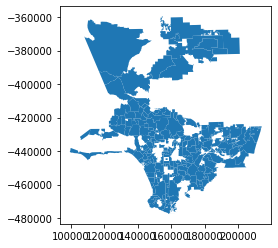

In [112]:
places_map_geo.plot()

---

### Export

In [113]:
places_map_geo[
    [
        "name",
        "mid_november",
        "mid_january",
        "pct_change",
        "rank_lower_is_better",
        "geometry",
    ]
].to_file("output/places_map_geo.geojson", driver="GeoJSON")

ERROR:fiona._env:output/places_map_geo.geojson: No such file or directory


In [71]:
# min_max_minimultiples.save("visuals/min_max_minimultiples.png")

In [72]:
# twocities_chart.save("visuals/twocities_chart.png")

In [73]:
# twocities_chart2.save("visuals/twocities_chart2.png")

In [74]:
# pop_histogram.save("visuals/pop_histogram.png")

In [75]:
surge_change_pivot.rename(
    columns={
        "mid_november": "case_rate_per_100k_mid-november",
        "mid_january": "case_rate_per_100k_mid-january",
    },
    inplace=True,
)

---

### Add demographics from 07-census-data-places

In [76]:
census = pd.read_csv("output/places_totals.csv")

In [77]:
surge_demos = pd.merge(surge_change_pivot, census, on="name")

In [78]:
surge_demos[surge_demos["name"] == "Westlake Village"]

,name,case_rate_per_100k_mid-november,case_rate_per_100k_mid-january,pct_change,rank_lower_is_better,rsa,est_pop,est_latino,est_anglo,est_black,est_asian,est_total_single_units,est_total_seven_more_units,est_total_housing_units,median_house_income,est_latino_pct,est_anglo_pct,est_black_pct,est_asian_pct,est_total_seven_more_units_pct,est_total_single_units_pct
186,Westlake Village,11.96,47.85,300.08,34.0,Santa Monica Mountains,6704.0,483.0,5537.0,98.0,395.0,604.0,16.0,2646.0,124822.0,7.2,82.59,1.46,5.89,0.6,22.83


### Places with the HIGHEST rates of homes that have seven or more residents

In [79]:
surge_demos[
    [
        "name",
        "rsa",
        "est_total_seven_more_units_pct",
        "pct_change",
        "rank_lower_is_better",
    ]
].sort_values("est_total_seven_more_units_pct", ascending=False).head(10)

,name,rsa,est_total_seven_more_units_pct,pct_change,rank_lower_is_better
48,East Rancho Dominguez,Harbor,22.81,378.26,66.0
116,Pacoima,San Fernando Valley,21.03,396.40,72.0
183,West Puente Valley,San Gabriel Valley,19.74,825.02,179.0
7,Arleta,San Fernando Valley,18.53,374.57,64.0
10,Avocado Heights,San Gabriel Valley,18.48,912.51,186.0
175,Walnut Park,Southeast,17.62,851.63,182.0
99,Lynwood,Southeast,17.53,583.22,137.0
58,Florence-Firestone,South L.A.,17.31,528.05,121.0
176,Watts,South L.A.,17.22,752.69,175.0
147,South El Monte,San Gabriel Valley,16.74,430.19,87.0


### Places with the LOWEST rates of homes that have seven or more residents

In [80]:
surge_demos[
    [
        "name",
        "rsa",
        "est_total_seven_more_units_pct",
        "pct_change",
        "rank_lower_is_better",
    ]
].sort_values("est_total_seven_more_units_pct", ascending=True).head(10)

,name,rsa,est_total_seven_more_units_pct,pct_change,rank_lower_is_better
104,Marina del Rey,Westside,0.03,419.99,84.0
25,Carthay,Central L.A.,0.04,293.32,32.0
181,West Hollywood,Central L.A.,0.06,46.16,1.0
27,Century City,Westside,0.10,308.33,38.0
76,Hollywood Hills,Central L.A.,0.15,185.38,7.0
73,Hermosa Beach,South Bay,0.16,252.39,19.0
20,Brentwood,Westside,0.18,200.00,10.0
187,Westwood,Westside,0.25,469.07,104.0
154,Studio City,San Fernando Valley,0.26,329.98,51.0
161,Toluca Lake,San Fernando Valley,0.29,266.67,23.0


### Places with largest coronavirus rate increases during surge

In [81]:
surge_demos[
    [
        "name",
        "rsa",
        "case_rate_per_100k_mid-november",
        "case_rate_per_100k_mid-january",
        "rank_lower_is_better",
        "pct_change",
        "est_latino_pct",
        "est_total_seven_more_units_pct",
    ]
].sort_values("rank_lower_is_better", ascending=True).tail(10)

,name,rsa,case_rate_per_100k_mid-november,case_rate_per_100k_mid-january,rank_lower_is_better,pct_change,est_latino_pct,est_total_seven_more_units_pct
49,East Whittier,San Gabriel Valley,94.23,904.64,184.0,860.03,51.76,2.30
118,Palms,Westside,82.05,818.20,185.0,897.20,22.90,0.51
10,Avocado Heights,San Gabriel Valley,118.08,1195.57,186.0,912.51,85.80,18.48
18,Beverlywood,Westside,53.14,538.98,187.0,914.26,10.44,1.40
141,Santa Fe Springs,Southeast,119.80,1236.11,188.0,931.81,82.49,8.49
78,Hyde Park,South L.A.,101.61,1152.73,189.0,1034.47,36.60,4.95
151,South San Gabriel,San Gabriel Valley,90.42,1039.78,190.0,1049.94,41.25,7.32
172,Vermont Square,South L.A.,156.72,1828.39,191.0,1066.66,63.40,15.17
93,Leimert Park,South L.A.,59.07,774.53,192.0,1211.21,25.70,3.22
138,San Marino,San Gabriel Valley,15.06,316.34,193.0,2000.53,6.65,1.24


### Places with smallest coronavirus rate increases during surge

In [82]:
surge_demos[
    [
        "name",
        "rsa",
        "case_rate_per_100k_mid-november",
        "case_rate_per_100k_mid-january",
        "rank_lower_is_better",
        "pct_change",
        "est_latino_pct",
        "est_total_seven_more_units_pct",
    ]
].sort_values("rank_lower_is_better", ascending=True).head(10)

,name,rsa,case_rate_per_100k_mid-november,case_rate_per_100k_mid-january,rank_lower_is_better,pct_change,est_latino_pct,est_total_seven_more_units_pct
181,West Hollywood,Central L.A.,211.09,308.52,1.0,46.16,10.50,0.06
3,Agua Dulce,Northwest County,240.50,408.85,2.0,70.00,23.23,2.19
100,Malibu,Santa Monica Mountains,100.30,208.32,3.0,107.70,6.54,0.82
38,Del Aire,South Bay,91.05,227.63,4.0,150.01,50.16,3.57
47,East Pasadena,San Gabriel Valley,46.85,124.94,5.0,166.68,26.80,2.67
56,Encino,San Fernando Valley,172.67,464.89,6.0,169.24,9.32,0.47
76,Hollywood Hills,Central L.A.,139.29,397.50,7.0,185.38,9.48,0.15
129,Rancho Park,Westside,106.71,304.88,8.0,185.71,13.51,0.47
170,Venice,Westside,103.29,309.87,10.0,200.00,18.64,0.70
20,Brentwood,Westside,125.99,377.97,10.0,200.00,5.68,0.18


In [83]:
surge_demos.sort_values("rank_lower_is_better", ascending=True).to_csv(
    "output/hayley/change_by_community.csv", index=False
)

### What's the relationship between our demographics and coronavirus rates? 

In [95]:
surge_demos_slim = surge_demos[
    [
        "name",
        "rsa",
        "est_pop",
        "case_rate_per_100k_mid-january",
        "pct_change",
        "est_latino_pct",
        "est_anglo_pct",
        "est_black_pct",
        "est_asian_pct",
        "est_total_seven_more_units_pct",
        "est_total_single_units_pct",
        "median_house_income",
    ]
]

In [96]:
surge_demos_slim.corr(method="pearson")

,est_pop,case_rate_per_100k_mid-january,pct_change,est_latino_pct,est_anglo_pct,est_black_pct,est_asian_pct,est_total_seven_more_units_pct,est_total_single_units_pct,median_house_income
est_pop,1.000000,0.204489,-0.072185,0.172641,-0.147830,-0.041613,-0.014934,0.080166,-0.111327,-0.151476
case_rate_per_100k_mid-january,0.204489,1.000000,0.305584,0.901472,-0.791340,0.157697,-0.332877,0.841461,-0.538883,-0.755528
pct_change,-0.072185,0.305584,1.000000,0.219093,-0.378335,0.259672,0.085312,0.244312,-0.273361,-0.280460
est_latino_pct,0.172641,0.901472,0.219093,1.000000,-0.816307,0.024108,-0.362574,0.856202,-0.601132,-0.702102
est_anglo_pct,-0.147830,-0.791340,-0.378335,-0.816307,1.000000,-0.328321,-0.067989,-0.748334,0.564785,0.796041
est_black_pct,-0.041613,0.157697,0.259672,0.024108,-0.328321,1.000000,-0.250833,0.126266,0.079670,-0.340007
est_asian_pct,-0.014934,-0.332877,0.085312,-0.362574,-0.067989,-0.250833,1.000000,-0.301198,-0.002836,0.107761
est_total_seven_more_units_pct,0.080166,0.841461,0.244312,0.856202,-0.748334,0.126266,-0.301198,1.000000,-0.675173,-0.575871
est_total_single_units_pct,-0.111327,-0.538883,-0.273361,-0.601132,0.564785,0.079670,-0.002836,-0.675173,1.000000,0.192256
median_house_income,-0.151476,-0.755528,-0.280460,-0.702102,0.796041,-0.340007,0.107761,-0.575871,0.192256,1.000000


In [108]:
scatter = (
    alt.Chart(surge_demos_slim)
    .mark_circle(size=100)
    .encode(
        x="median_house_income:Q",
        y="case_rate_per_100k_mid-january:Q",
        color=alt.Color("rsa", scale=alt.Scale(scheme="category20")),
        size="est_pop:Q",
        tooltip=[
            "name",
            "est_pop",
            "case_rate_per_100k_mid-january",
            "est_total_seven_more_units_pct",
        ],
    )
)

text = (
    alt.Chart(surge_demos_slim)
    .mark_text(align="left", baseline="middle", dx=7)
    .encode(
        x="median_house_income:Q",
        y="case_rate_per_100k_mid-january:Q",
        text="name",
    )
)

(scatter + text).properties(width=1000, height=1000)

alt.LayerChart(...)

In [103]:
(scatter + text).properties(width=2000, height=2000).save(
    "visuals/places_scatter_house_income.png"
)

In [104]:
min_max_minimultiples.properties(width=2000, height=2000).save(
    "visuals/min_max_minimultiples.png"
)

In [105]:
twocities_chart2.properties(width=2000, height=2000).save(
    "visuals/twocities_chart2.png"
)

In [106]:
twocities_chart.properties(width=2000, height=2000).save("visuals/twocities_chart.png")